<h1><center>Laboratorio 7: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Primavera 2025</strong></center>

### Cuerpo Docente:

- Profesores: Diego Cortez, Gabriel Iturra
- Auxiliares: Melanie Peña, Valentina Rojas
- Ayudantes: Nicolás Cabello, Cristopher Urbina

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Diego Acuña
- Nombre de alumno 2: Tomás Ramírez

### **Link de repositorio de GitHub:** [Repositorio](https://github.com/Diego-Acuna/mds-laboratorios)

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Fecha de entrega: Entregas Martes a las 23:59.
- Instrucciones del lab el viernes a las 16:15 en formato online. Asistencia no es obligatoria, pero se recomienda **fuertemente** asistir.
- <u>Prohibidas las copias</u>. Cualquier intento de copia será debidamente penalizado con el reglamento de la escuela.
- Tienen que subir el laboratorio a u-cursos y a su repositorio de github. Labs que no estén en u-cursos no serán revisados. Recuerden que el repositorio también tiene nota.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Pueden usar cualquier material del curso que estimen conveniente.


### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('diabetes_data.csv')
df.head(5)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)
from sklearn.inspection import PartialDependenceDisplay

import xgboost as xgb
from xgboost import XGBClassifier

import shap
from functools import lru_cache
import re

## 2. Clasificación de pacientes con diabetes (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

Tareas:
1. En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento, realice los siguientes pasos:
  * Realice una breve exploración de los datos y determine si aplicará transformaciones (MinMaxScaler, StandardScaler, etc.) en alguna/s de las variables. (1 punto)
  * Cree un conjunto de entrenamiento y uno de prueba, con una proporción de 1/3 en el conjunto de prueba. (0.5 puntos)
  * Cree un ColumnTransformer de preprocesamiento donde aplique las transformaciones determinadas anteriormente. Fije el parámetro `verbose_feature_names_out=False` y fije la salida del ColumnTransformer en formato pandas mediante el método `.set_output(transform='pandas')`. (1 punto)
  *  Cree un pipeline donde integre el preprocesamiento y el modelo `XGBoost` y entrene el modelo. Luego utilice `classification_report(..)` para reportar el desempeño del modelo. (1 punto)

Comente sus decisiones y los resultados obtenidos con el modelo.

2. Luego, le pide responder las siguientes preguntas:
  *  ¿Es acaso un buen predictor de diabetes? (0.5 puntos)
  * ¿Qué buscan explicar las métricas utilizadas? (0.5 puntos)
  * ¿Las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?(0.5 puntos)

In [3]:
!pip install xgboost

In [ ]:
X = df.drop(columns=["Diabetes"])
y = df["Diabetes"]

# Tipos, faltantes y cardinalidad
overview = (
    pd.DataFrame({
        "dtype": X.dtypes.astype(str),
        "n_miss": X.isna().sum(),
        "pct_miss": X.isna().mean(),
        "n_unique": X.nunique()
    })
    .sort_index()
)

# Numéricas
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Resumen para continuas vs binarias/ordinales
cont_like = [c for c in num_cols if X[c].nunique() > 20]           # ~ continuas/recuentos
bin_or_lowcard = [c for c in num_cols if X[c].nunique() <= 10]     # ~ binarias/ordinales

# Asimetría y % ceros
summary_num = (
    X[num_cols].describe(percentiles=[.25,.5,.75]).T
    .assign(
        skew=X[num_cols].skew(numeric_only=True).round(3),
        zeros_pct=(X[num_cols].eq(0).mean()*100).round(2)
    )
    .rename(columns={"25%":"q1","50%":"median","75%":"q3","count":"n"})
    [["n","mean","std","min","q1","median","q3","max","skew","zeros_pct"]]
    .sort_index()
)

print(f"Shape X: {X.shape} | Faltantes totales: {int(X.isna().sum().sum())}")
print("Continuas / recuentos:", cont_like)
print("Binarias/low-card:", bin_or_lowcard)
display(overview)
display(summary_num)

# Decisión de transformaciones para XGBoost:
# - Sin escalamiento (passthrough)
# - Sin imputación (no hay missings)
# - Sin codificación (ya está en numérico)

Shape X: (70692, 17) | Faltantes totales: 0
Continuas / recuentos: ['BMI', 'MentHlth', 'PhysHlth']
Binarias/low-card: ['Sex', 'HighChol', 'CholCheck', 'Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'DiffWalk', 'Stroke', 'HighBP']


,dtype,n_miss,pct_miss,n_unique
Age,float64,0,0.0,13
BMI,float64,0,0.0,80
CholCheck,float64,0,0.0,2
DiffWalk,float64,0,0.0,2
Fruits,float64,0,0.0,2
GenHlth,float64,0,0.0,5
HeartDiseaseorAttack,float64,0,0.0,2
HighBP,float64,0,0.0,2
HighChol,float64,0,0.0,2
HvyAlcoholConsump,float64,0,0.0,2


,n,mean,std,min,q1,median,q3,max,skew,zeros_pct
Age,70692.0,8.584055,2.852153,1.0,7.0,9.0,11.0,13.0,-0.546,0.00
BMI,70692.0,29.856985,7.113954,12.0,25.0,29.0,33.0,98.0,1.719,0.00
CholCheck,70692.0,0.975259,0.155336,0.0,1.0,1.0,1.0,1.0,-6.119,2.47
DiffWalk,70692.0,0.252730,0.434581,0.0,0.0,0.0,1.0,1.0,1.138,74.73
Fruits,70692.0,0.611795,0.487345,0.0,0.0,1.0,1.0,1.0,-0.459,38.82
GenHlth,70692.0,2.837082,1.113565,1.0,2.0,3.0,4.0,5.0,0.172,0.00
HeartDiseaseorAttack,70692.0,0.147810,0.354914,0.0,0.0,0.0,0.0,1.0,1.985,85.22
HighBP,70692.0,0.563458,0.495960,0.0,0.0,1.0,1.0,1.0,-0.256,43.65
HighChol,70692.0,0.525703,0.499342,0.0,0.0,1.0,1.0,1.0,-0.103,47.43
HvyAlcoholConsump,70692.0,0.042721,0.202228,0.0,0.0,0.0,0.0,1.0,4.523,95.73


In [5]:
# Split 2/3 - 1/3 (estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, stratify=y, random_state=42
)

# Preprocesamiento: passthrough
pre = make_column_transformer(
    ("passthrough", X.columns),
    verbose_feature_names_out=False
)

pre = pre.set_output(transform="pandas")

# Clasificador XGBoost
# Ajuste por desbalance: scale_pos_weight = (#neg / #pos)
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
spw = neg / pos if pos > 0 else 1.0

xgb = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=spw
)

pipe = Pipeline([("pre", pre), ("clf", xgb)])

# Entrenamos y evaluamos
pipe.fit(X_train, y_train)

y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df   = pd.DataFrame(report_dict).T

cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)  # AUC-PR, más informativa con desbalance

print(f"Prevalencia (test): {y_test.mean():.3f}")
print(f"ROC AUC (test):     {roc_auc:.3f}")
print(f"AP / AUC-PR (test): {ap:.3f}")
print("Matriz de confusión:\n", cm)
display(report_df)

Prevalencia (test): 0.500
ROC AUC (test):     0.828
AP / AUC-PR (test): 0.801
Matriz de confusión:
 [[8305 3477]
 [2397 9385]]


,precision,recall,f1-score,support
0.0,0.776023,0.704889,0.738748,11782.000000
1.0,0.729669,0.796554,0.761646,11782.000000
accuracy,0.750721,0.750721,0.750721,0.750721
macro avg,0.752846,0.750721,0.750197,23564.000000
weighted avg,0.752846,0.750721,0.750197,23564.000000


1. Las decisiones sobre transformaciones fueron:

* Imputación: no aplica (0% de faltantes).
* Escalamiento (`StandardScaler`, `MinMaxScaler`): no aplicar pues XGBoost es invariante a escalas, reescalar no aporta al desempeño y dificulta interpretar umbrales en PDP/SHAP.
* Codificación: no requerida pues todas las columnas ya son numéricas. `GenHlth` (1–5) y `Age` (1–13) se mantienen como ordinales; el resto son binarias (0/1).
* Transformaciones de asimetría (log, winsorizar): no necesarias para un modelo basado en árboles. Mantener las unidades originales facilita interpretación clínica posterior.
* Clase positiva desbalanceada: no es el caso (prevalencia 0.50). El `scale_pos_weight` quedó en ≈1 (efecto neutro).

#### Comentario de las decisiones y resultados del modelo

Configuración: Pipeline = `preprocesamiento(passthrough)` → `XGBClassifier` con regularización moderada (`max_depth=4`, `subsample=0.8`, `colsample_bytree=0.8`) y `tree_method="hist"` para eficiencia. Conjunto de prueba = 1/3, estratificado.

Desempeño en test.

* Accuracy: 0.751
* ROC AUC: 0.828 → buena separabilidad global.
* AUC-PR: 0.801 (> 0.50 de la prevalencia) → buen poder de detección de la clase positiva.
* Reporte por clase:

  * Clase 1 (diabetes): *precision* 0.730, *recall* 0.797, F1 0.762.
  * Clase 0 (no diabetes): *precision* 0.776, *recall* 0.705, F1 0.739.
* Matriz de confusión:  
  TN=8 305, FP=3 477, FN=2 397, TP=9 385  
  → FNR ≈ 2 397/11 782 ≈ 20.3% (diabéticos pasados por alto)  
  → FPR ≈ 3 477/11 782 ≈ 29.5% (alarmas falsas)   

Notamos que el modelo logra alta sensibilidad para la clase 1 (≈0.80), que suele ser prioritaria en un contexto de tamizaje; la especificidad (≈0.70) es razonable dado el compromiso sensibilidad–especificidad. Frente a un clasificador trivial (50% de acierto) hay un salto a ≈75% con AUC 0.83.

2) Respuestas a preguntas:

- ¿Es un buen predictor?    
Sí. Con ROC AUC = 0.828, AUC-PR = 0.801 (> 0.50 de prevalencia), F1₁ ≈ 0.76 y recall₁ ≈ 0.80, el modelo separa bien a diabéticos/no diabéticos y logra alta sensibilidad, adecuada para tamizaje.

- ¿Qué explican las métricas?
  * Precision (PPV): de los clasificados como 1, ¿qué proporción realmente lo es?
  * Recall/Sensibilidad: de los 1 reales, ¿cuántos detecta?
  * F1: equilibrio entre precision y recall.
  * Accuracy: acierto global.
  * ROC AUC: capacidad de discriminación a todos los umbrales.
  * AUC-PR: calidad en la clase positiva (más informativa cuando hay desbalance).

- ¿Garantizan buena elección de features?   
No. Miden desempeño predictivo, no relevancia/estabilidad de variables. Para juzgar qué usa el modelo se requieren métodos de interpretabilidad (PFI, PDP, SHAP), análisis de estabilidad y validación con criterio de dominio.

## 3. Importancia de las features con XGBoost (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Tareas:
1. Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. `Hint:` Puede acceder a un paso de un pipeline por su nombre mediante el método `.named_steps[...]` (3 puntos)
2. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. (1 punto)
3. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método? (1 punto)

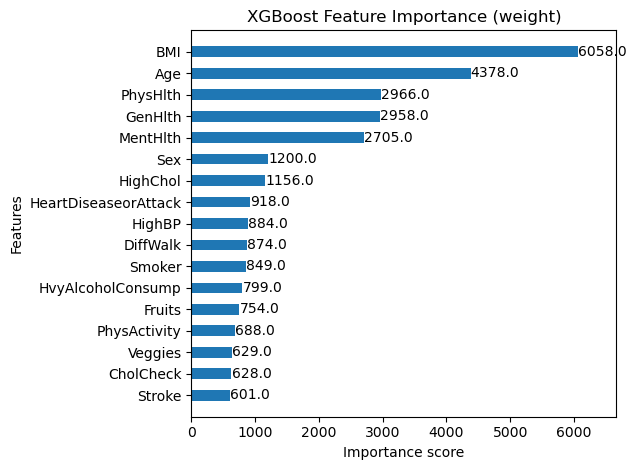

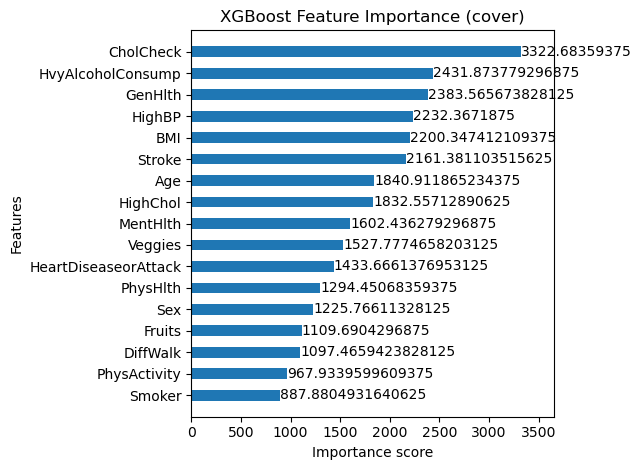

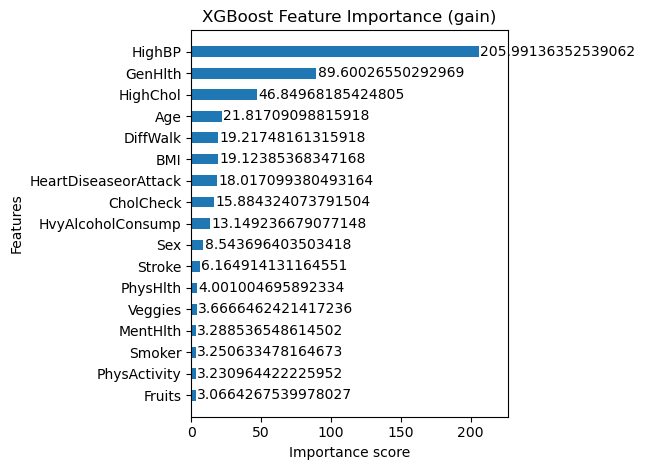

,weight,cover,gain
feature,,,
HighBP,0.030436,0.075538,0.424844
GenHlth,0.101842,0.080655,0.184795
HighChol,0.039800,0.062010,0.096625
Age,0.150732,0.062292,0.044996
DiffWalk,0.030091,0.037136,0.039635
BMI,0.208573,0.074455,0.039442
HeartDiseaseorAttack,0.031606,0.048512,0.037159
CholCheck,0.021622,0.112432,0.032760
HvyAlcoholConsump,0.027509,0.082289,0.027119


In [ ]:
# Booster desde el pipeline entrenado
booster = pipe.named_steps["clf"].get_booster()

# Nombres de columnas para que los gráficos no muestren f0, f1, ...
try:
    feat_names = list(pipe.named_steps["pre"].get_feature_names_out())
except Exception:
    # fallback: columnas originales (passthrough)
    feat_names = list(df.drop(columns=["Diabetes"]).columns)

# Asignar nombres si calzan en número
try:
    if booster.num_features() == len(feat_names):
        booster.feature_names = feat_names
except Exception:
    pass

# Gráficos: top-20 por cada criterio
for imp in ["weight", "cover", "gain"]:
    ax = xgb.plot_importance(
        booster,
        importance_type=imp,
        max_num_features=20,
        show_values=True,
        grid=False,
        height=0.5
    )
    ax.set_title(f"XGBoost Feature Importance ({imp})")
    ax.figure.tight_layout()
    plt.show()

# Tabla con las tres importancias
def _imp(booster, kind):
    s = pd.Series(booster.get_score(importance_type=kind))
    s.index.name = "feature"; s.name = kind
    return s

imp_df = pd.concat([
    _imp(booster,"weight"),
    _imp(booster,"cover"),
    _imp(booster,"gain")
], axis=1).fillna(0)

# versión normalizada por columna (suma=1), ordenada por 'gain'
imp_norm = imp_df.div(imp_df.sum(axis=0).replace(0, np.nan), axis=1)
display(imp_norm.sort_values("gain", ascending=False).head(20))

#### (2) ¿Son compatibles los tres métodos?

Parcialmente. Los tres coinciden en un núcleo de variables relevantes (p. ej., `HighBP`, `GenHlth`, `HighChol`, `Age`, `BMI`, `DiffWalk`, `HeartDiseaseorAttack`, `CholCheck`, `HvyAlcoholConsump`), pero el orden cambia y hay diferencias marcadas:

* weight (frecuencia de uso): lideran `BMI` y `Age`; son continuas con muchos puntos de corte y aparecen en muchos splits (aunque algunos aporten poco).
* cover (cobertura): domina `CholCheck` (y `HvyAlcoholConsump`), señal de que estas variables se emplean temprano o en reglas amplias que afectan a muchos registros.
* gain (reducción de pérdida): arrasa `HighBP`, seguido por `GenHlth` y `HighChol`; indica que, aunque puedan usarse menos veces, sus splits son muy informativos.

Estas discrepancias se explican por (i) la definición de cada métrica, (ii) la cardinalidad (continuas tienden a inflar *weight*), (iii) interacciones y colinealidad (p. ej., `HighBP`, `HighChol`, `HeartDiseaseorAttack`), que hacen que el árbol “elija” una de varias variables equivalentes y reparta/“canibalice” importancias, y (iv) la profundidad del split (splits altos elevan *cover* y, si son muy informativos, también *gain*).

Lectura de los resultados sería:

* `BMI` muy alto en *weight* pero no lidera en *gain* ⇒ se usa mucho, cada uso aporta moderado.
* `HighBP` discretamente usado (*weight* medio) pero #1 en *gain* ⇒ pocos splits, muy potentes.
* `CholCheck` alto en *cover* ⇒ aparece en particiones amplias; su *gain* es intermedio.

#### (3) ¿Bastan estas importancias para la interpretabilidad? ¿Debilidad?

No, no son suficientes. Son medidas globales y dependientes del modelo que resumen “cómo se partió el árbol” durante el entrenamiento, pero no entregan:

* Dirección ni forma del efecto (¿sube o baja el riesgo al aumentar `BMI`? ¿lineal, umbral, no monótono?).
* Explicaciones locales por paciente (por qué un individuo fue clasificado como 1).
* Robustez ante correlación/colinealidad (reparten o sesgan la importancia).
* Equidad entre variables: *weight/gain* favorecen variables con mayor cardinalidad o con más oportunidades de split.
* Estabilidad: pueden variar con la semilla y la muestra, y están ancladas al set de entrenamiento.

## 4. Métodos Agnósticos Globales (10 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Tareas:
1. Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. `Nota:`Tenga cuidado con el orden de las columnas de este método. `Hint:` Puede obtener los features del clasificador con su respectivo orden mediante el método `.get_booster().feature_names` (2 puntos)
2. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala esta?). (2 puntos)
3. Visualice los resultados de este método en un gráfico. (2 puntos)
4. Además, responda las siguientes preguntas:
  - ¿Cómo mide la importancia de las features su propuesta? (1 punto)
  - ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿tienen sentido? (1 punto)
  - ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior? (1 punto)
  - Nombre y explique 3 ventajas y 3 desventajas del método implementado. (1 punto)

Métrica base en test (roc_auc): 0.828


,feature,mean_decrease,std
0,GenHlth,0.060981,0.001956
1,BMI,0.038692,0.001170
2,Age,0.030175,0.000821
3,HighBP,0.017182,0.000995
4,HighChol,0.011935,0.000584
5,HvyAlcoholConsump,0.003888,0.000438
6,CholCheck,0.003873,0.000397
7,HeartDiseaseorAttack,0.002711,0.000442
8,Sex,0.001859,0.000288
9,DiffWalk,0.001788,0.000268


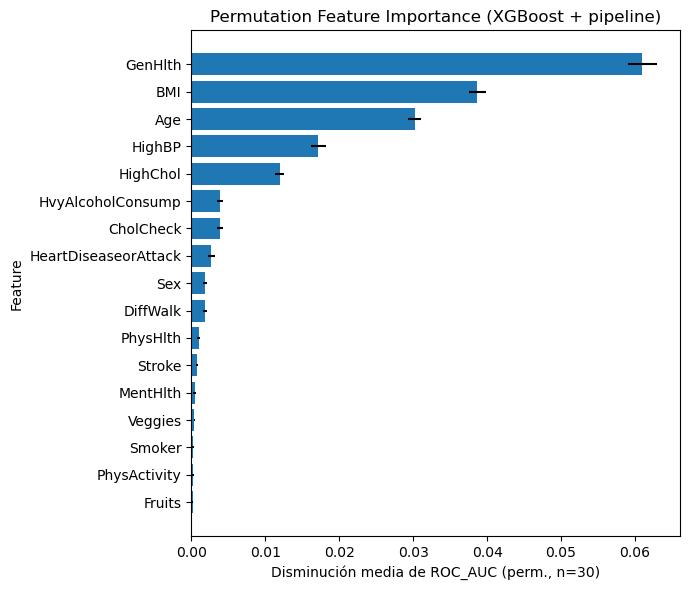

In [ ]:
# Configuración
N_REPEATS = 30
METRIC = "roc_auc"

# Utilidad: orden de columnas consistente con el booster de XGBoost
def _ordered_input_columns(pipe, X):
    clf = pipe.named_steps["clf"]
    booster = clf.get_booster()
    booster_names = booster.feature_names  # p.ej. ['f0','f1',...] o nombres reales
    try:
        input_cols = list(pipe.named_steps["pre"].transformers_[0][2])
    except Exception:
        input_cols = list(X.columns)

    if booster_names is None:
        return input_cols

    # Caso de nombres 'f0','f1',...: mapear por índice
    if all(isinstance(bn, str) and bn.startswith("f") and bn[1:].isdigit() for bn in booster_names):
        idx = [int(bn[1:]) for bn in booster_names]
        return [input_cols[i] for i in idx]

    # Si booster_names ya coincide con nombres reales
    if set(booster_names) == set(input_cols):
        # conservar el orden del booster
        return list(booster_names)

    # Fallback seguro
    return input_cols

def _score(y_true, y_proba, metric):
    if metric == "roc_auc":
        return roc_auc_score(y_true, y_proba)
    elif metric == "ap":
        return average_precision_score(y_true, y_proba)
    else:
        raise ValueError("Métrica no soportada")

def permutation_importance(pipe, X, y, n_repeats=30, metric="roc_auc", random_state=42, topk=None):
    rng = np.random.RandomState(random_state)
    cols = _ordered_input_columns(pipe, X)
    X = X[cols].copy()  # asegurar orden correcto

    # Baseline
    base_proba = pipe.predict_proba(X)[:, 1]
    base = _score(y, base_proba, metric)

    # Importancias por permutación
    out = []
    for col in cols:
        scores = np.empty(n_repeats)
        for r in range(n_repeats):
            Xp = X.copy()
            Xp[col] = rng.permutation(Xp[col].values)  # permutar SOLO esa columna
            proba = pipe.predict_proba(Xp)[:, 1]
            scores[r] = base - _score(y, proba, metric)
        out.append((col, scores.mean(), scores.std()))

    imp = pd.DataFrame(out, columns=["feature", "mean_decrease", "std"])
    imp = imp.sort_values("mean_decrease", ascending=False).reset_index(drop=True)
    if topk is not None:
        imp = imp.head(topk)

    return imp, base

# Ejecutar PFI (30 repeticiones) y graficar
imp_df, baseline = permutation_importance(pipe, X_test, y_test, n_repeats=N_REPEATS,
                                          metric=METRIC, random_state=42, topk=20)

print(f"Métrica base en test ({METRIC}): {baseline:.3f}")
display(imp_df)

# Gráfico: barras con error (std) de la disminución media de la métrica
fig, ax = plt.subplots(figsize=(7, 6))
ax.barh(imp_df["feature"][::-1], imp_df["mean_decrease"][::-1], xerr=imp_df["std"][::-1])
ax.set_xlabel(f"Disminución media de {METRIC.upper()} (perm., n={N_REPEATS})")
ax.set_ylabel("Feature")
ax.set_title("Permutation Feature Importance (XGBoost + pipeline)")
plt.tight_layout()
plt.show()

Primero notamos que las std son pequeñas (∼0.0006–0.002): el ranking es estable en 30 permutaciones. Std alta indicaría inestabilidad por correlación entre variables, efectos débiles o alta varianza de la métrica.

Ahora con respecto a las preguntas planteadas:

#### ¿Cómo mide la importancia de las features su propuesta?

Con Permutation Feature Importance sobre el set de test: para cada feature, se permuta su columna (manteniendo el resto fijo), se vuelve a predecir y se calcula la pérdida de desempeño (Δ de AUC en nuestro caso). La importancia es el promedio de esas caídas en 30 repeticiones; el error es su desviación estándar.

#### ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿tienen sentido?

1. `GenHlth`: mayor caída de AUC ⇒ el estado de salud auto-reportado resume riesgos metabólicos y estilo de vida; es muy informativa.
2. `BMI`: coherente con resistencia a la insulina y riesgo de diabetes tipo 2.
3. `Age`: la incidencia aumenta con edad; esperable.
4. `HighBP`: comorbilidad cardiometabólica fuertemente asociada.
5. `HighChol`: otro marcador metabólico relevante.
   En conjunto, las 5 primeras tienen sentido clínico y con lo visto en la sección anterior (aunque con distinto orden).

#### ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?

* En XGBoost nativo, `gain` ponía #1 a `HighBP`, mientras que PFI posiciona #1 `GenHlth` y baja `HighBP` al 4º lugar: PFI mide impacto real en generalización; *gain* resume reducción de pérdida en entrenamiento.
* `BMI` y `Age` estaban muy arriba por *weight* (muchos splits). En PFI se mantienen fuertes pero no por su frecuencia, sino por efecto marginal en la métrica.
* `CholCheck` lideraba en *cover* (splits amplios), pero en PFI su efecto es más modesto: partir “a muchos” no implica aportar más AUC.
  Conclusión: PFI corrige sesgos estructurales de *weight/cover* y ofrece una lectura más cercana al valor predictivo marginal de cada variable en test. Aun así, puede verse afectada por correlaciones (reparto de importancia).

#### Nombre y explique 3 ventajas y 3 desventajas del método implementado.

**Ventajas**

1. Agnóstico al modelo: funciona con cualquier estimador y cualquier métrica.
2. Interpretable: la magnitud es “cuánto cae el desempeño” al romper la señal de una feature.
3. Evalúa en test: refleja utilidad real y no la dinámica de entrenamiento del árbol.

**Desventajas**

1. Sesgo por correlación: si hay variables sustitutas, permutar una sobre-estima su importancia o la reparte de forma poco estable.    
   *Mitigación*: PFI condicional/agrupado o análisis por grupos de features.
2. Costo computacional: requiere muchas predicciones (n_features × repeticiones).   
   *Mitigación*: limitar a top-k, paralelizar o reducir repeticiones.
3. Off-manifold: la permutación puede generar combinaciones poco realistas y alterar la distribución.    
   *Mitigación*: permutar dentro de estratos (p. ej., por edad/sexo) o usar métodos basados en SHAP/contrafácticos.

## 5. Métodos Agnósticos Locales (20 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/10-24-2024/oMCrLI.gif" width="400">
</p>

### 5.1 Calculando Shap Values (4 puntos)

Tareas:
1. Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. (2 puntos)
2. ¿Qué representa cada número en su resultado? (1 punto)
3. ¿Es posible atribuir un significado a la positividad/negatividad de cada valor? (1 punto)

In [8]:
!pip install shap

In [9]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [10]:
# Inserte código para calcular shapley values aquí
clf = pipe.named_steps["clf"]
pre = pipe.named_steps["pre"]

def _feat_names(pre, X):
    try:
        return list(pre.get_feature_names_out())
    except Exception:
        return list(X.columns)

# Transformar con el preprocesamiento del pipeline
X_train_t = pre.transform(X_train)
X_test_t  = pre.transform(X_test)

# Explainer: tree_path_dependent + salida RAW (margen/log-odds)
explainer = shap.TreeExplainer(
    model=clf,
    feature_perturbation="tree_path_dependent",
    model_output="raw"
)

# SHAP values sobre test
sv = explainer(X_test_t, check_additivity=False)

# Objetos que usaremos después
shap_values   = sv.values                        # (n_muestras, n_features) en margen
base_values   = np.atleast_1d(sv.base_values)    # esperado del margen
feature_names = sv.feature_names or list(X_test_t.columns)
X_test_shap   = X_test_t

# DataFrame conveniente
shap_df = pd.DataFrame(shap_values, columns=feature_names, index=X_test.index)

print("SHAP shape:", shap_values.shape)
print("Base value (raw, ej.):", base_values[0])
display(shap_df.iloc[0].abs().sort_values(ascending=False).head(10))

# Reconstruir probabilidad para verificar consistencia
sigmoid = lambda z: 1.0 / (1.0 + np.exp(-z))
logit_pred = base_values + shap_values.sum(axis=1)        # margen = base + suma SHAP
p_from_shap = sigmoid(logit_pred)                          # probabilidad reconstruida
p_model = pipe.predict_proba(X_test)[:, 1]
print("Δ prob. media |p_shap - p_model|:", float(np.abs(p_from_shap - p_model).mean()))

SHAP shape: (23564, 17)
Base value (raw, ej.): 0.0002819904


GenHlth                 0.624353
HighBP                  0.432584
BMI                     0.324186
HighChol                0.229482
Sex                     0.093139
Age                     0.083293
DiffWalk                0.062848
HeartDiseaseorAttack    0.046061
MentHlth                0.037944
HvyAlcoholConsump       0.030438
Name: 44379, dtype: float32

Δ prob. media |p_shap - p_model|: 1.821859711981233e-07


#### 2) ¿Qué representa cada número en su resultado?

Cada entrada $\phi_{ij}$ (fila $i$, feature $j$) es la contribución aditiva de la feature $j$ en el paciente $i$ sobre la salida del modelo en la escala “raw” (margen / log-odds para `binary:logistic`). Formalmente,
$$
f_{\text{raw}}(x_i) = \phi_0 + \sum_{j=1}^{p} \phi_{ij},
$$
donde $\phi_0$ es el valor base (`base_value`). La probabilidad predicha se recupera como
$$
\hat{p}(x_i) = \sigma\left(\phi_0 + \sum_j \phi_{ij}\right), \quad \sigma(z)=\frac{1}{1+e^{-z}}.
$$
El módulo $|\phi_{ij}|$ mide la fuerza del aporte local de la feature $j$ para ese paciente.

#### 3) ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

Sí. En binario y con salida raw:

* $\phi_{ij} > 0$ empuja hacia la clase 1 (Diabetes), incrementando los log-odds y, por ende, la probabilidad.
* $\phi_{ij} < 0$ empuja hacia la clase 0 (No diabetes), reduciendo los log-odds.
* El signo es local: depende del valor concreto de la feature y de sus interacciones con las demás. Por ejemplo, un BMI alto suele dar $\phi_{ij}>0$ (sube riesgo), mientras que un BMI bajo tenderá a $\phi_{ij}<0$; pero el signo puede variar según el contexto de otras variables (p. ej., `GenHlth`, `HighBP`).


### 5.2 Aporte local (4 puntos)

1. Usando los *shap values* calculados, grafique el **aporte local** de las diferentes variables para las instancias **1**, **9** y **150** (1 punto).

2. Interprete sus resultados y responda:

  - ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? (1 punto)

  - ¿Existe algún patrón común entre las instancias analizadas? (1 punto)

  - ¿Es posible generalizar estas conclusiones a todo el dataset? (1 punto)

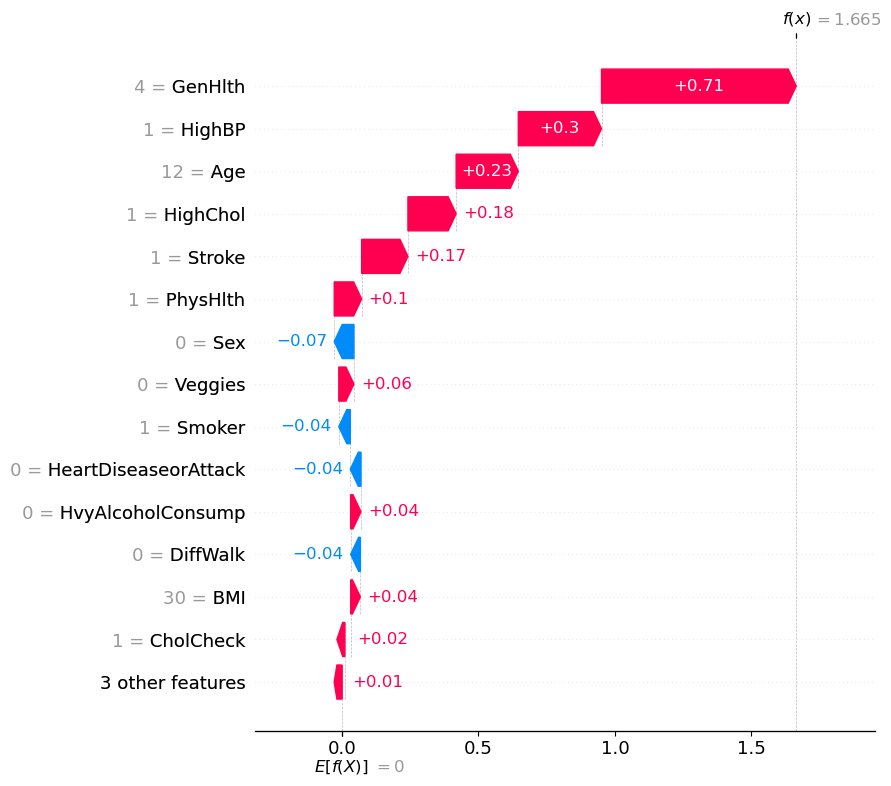

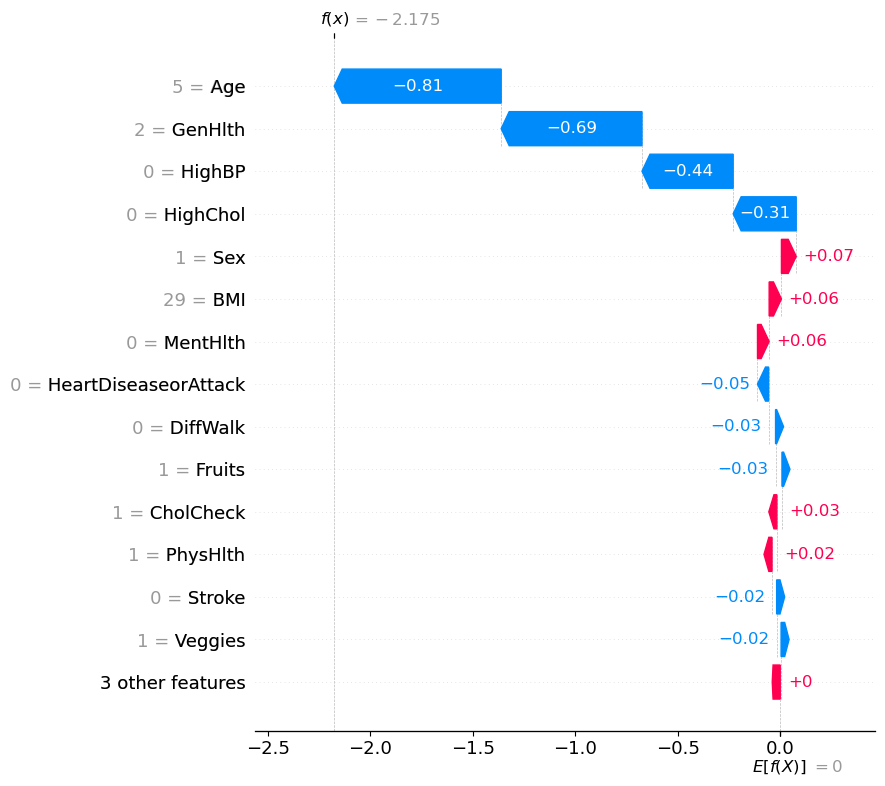

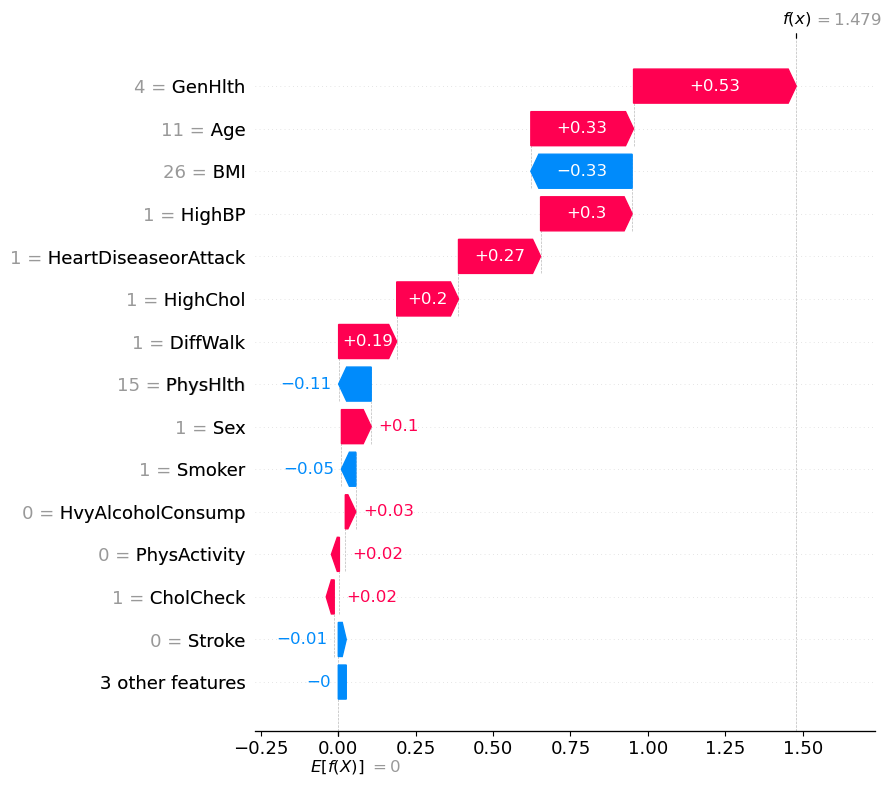


Top-10 |SHAP| para instancia 1:


,shap_value,feature_value
GenHlth,0.713654,4.0
HighBP,0.304982,1.0
Age,0.227848,12.0
HighChol,0.176663,1.0
Stroke,0.169654,1.0
PhysHlth,0.100548,1.0
Sex,-0.072190,0.0
Veggies,0.055429,0.0
Smoker,-0.042176,1.0
HeartDiseaseorAttack,-0.039136,0.0



Top-10 |SHAP| para instancia 9:


,shap_value,feature_value
Age,-0.814235,5.0
GenHlth,-0.686585,2.0
HighBP,-0.444675,0.0
HighChol,-0.307510,0.0
Sex,0.072126,1.0
BMI,0.059905,29.0
MentHlth,0.056819,0.0
HeartDiseaseorAttack,-0.054201,0.0
DiffWalk,-0.033896,0.0
Fruits,-0.031246,1.0



Top-10 |SHAP| para instancia 150:


,shap_value,feature_value
GenHlth,0.525282,4.0
Age,0.331700,11.0
BMI,-0.327165,26.0
HighBP,0.295684,1.0
HeartDiseaseorAttack,0.265093,1.0
HighChol,0.199558,1.0
DiffWalk,0.187528,1.0
PhysHlth,-0.105280,15.0
Sex,0.096294,1.0
Smoker,-0.046714,1.0


In [ ]:
# Inserte código para generar gráficos de aporte local aquí

# Helper para construir la explicación de una fila (formato esperado por shap.plots.waterfall)
def explanation_for(i: int):
    vals = np.asarray(shap_values)[i]
    base = np.atleast_1d(base_values)[i if np.ndim(base_values) > 0 else 0]
    data = np.asarray(X_test_shap.iloc[i].values)
    return shap.Explanation(values=vals, base_values=base, data=data, feature_names=feat_names)

# Índices del enunciado: 1, 9, 150
row_indices = [1, 9, 150]

# Graficamos waterfalls (aporte local) para cada instancia
for ridx in row_indices:
    exp = explanation_for(ridx)
    shap.plots.waterfall(exp, max_display=15, show=True)

# Fallback adicional (tabla de top±10 por |SHAP| para cada instancia)
def top_table(i: int, k: int = 10):
    s = pd.Series(shap_values[i], index=feat_names).sort_values(key=np.abs, ascending=False)
    return pd.DataFrame({"shap_value": s.head(k), "feature_value": X_test_shap.iloc[i][s.head(k).index]})

for ridx in row_indices:
    print(f"\nTop-10 |SHAP| para instancia {ridx}:")
    display(top_table(ridx, k=10))

- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?

  * Instancia 1 (riesgo alto, $f(x)\approx 1.67$)   
    Empujan ↑: `GenHlth=4` (salud autorreportada peor), `HighBP=1`, `Age=12` (mayor edad), `HighChol=1`, `Stroke=1`, `PhysHlth=1`.    
    Empujan ↓: `Sex=0` (según tu codificación, el sexo 0 reduce riesgo), `Smoker=1` y `HeartDiseaseorAttack=0` con efectos menores.   
    Lectura: comorbilidades cardiometabólicas y mal estado general elevan fuertemente el score.   

  * Instancia 9 (riesgo bajo, $f(x)\approx -2.18$)    
    Empujan ↓: `Age=5` (más joven), `GenHlth=2` (salud muy buena), `HighBP=0`, `HighChol=0`, `DiffWalk=0`, `HeartDiseaseorAttack=0`.    
    Empujan ↑ (pequeños): `Sex=1`, `BMI=29` (cerca del umbral), `MentHlth=0` (efecto marginal leve).    
    Lectura: la ausencia de comorbilidades y buena autopercepción de salud tiran el score hacia la clase 0.   

  * Instancia 150 (riesgo alto, $f(x)\approx 1.48$)   
    Empujan ↑: `GenHlth=4`, `Age=11`, `HighBP=1`, `HeartDiseaseorAttack=1`, `HighChol=1`, `DiffWalk=1`, `Sex=1`.    
    Empujan ↓: `BMI=26` (por debajo del umbral ≈30 que el modelo usa con más fuerza), `PhysHlth=15` y `Smoker=1` con efecto pequeño.    
    Lectura: de nuevo pesan mucho el estado general y las comorbilidades; aquí `BMI` actúa a la baja por quedar en zona “sobrepeso” pero no “obesidad”.   

- ¿Existe algún patrón común entre las instancias analizadas?

  Sí: el núcleo explicativo se repite. `GenHlth`, `Age`, `HighBP` y `HighChol` dominan el aporte local; cuando están en “valores de riesgo” empujan ↑ el log-odds, y cuando están en su contraparte empujan ↓. `BMI` aparece con signo dependiente de umbrales (≈30), coherente con un efecto no lineal.

- ¿Es posible generalizar estas conclusiones a todo el dataset?

  Solo parcialmente. Estas conclusiones son locales; muestran cómo el modelo razona para estas tres personas. El patrón coincide con lo visto en PFI (importancias globales) y es razonable clínicamente, lo que sugiere una tendencia general. Para generalizar con respaldo, corresponde:

  * usar SHAP summary plot (distribución global de (|\phi_j|) y signos),
  * inspeccionar PDP/ICE de variables clave (forma/dirección del efecto),
  * y verificar estabilidad en *bootstraps* o *CV*.

### 5.3 Aporte global (4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

In [ ]:
# Utils interpretabilidad
def _feature_names_from_pre(pre, X_ref):
    try:
        return list(pre.get_feature_names_out())
    except Exception:
        return list(X_ref.columns)

def ensure_df_from_pre(pre, X):
    Xt = pre.transform(X)
    if not isinstance(Xt, pd.DataFrame):
        Xt = pd.DataFrame(Xt, columns=_feature_names_from_pre(pre, X), index=X.index)
    return Xt

@lru_cache(None)
def get_sv_cached():
    """
    Devuelve shap.Explanation 'sv' en modo RAW (log-odds) sin reentrenar.
    Reutiliza objetos globales si existen; si no, los reconstruye de forma segura.
    """
    # Si ya existe 'sv'
    if 'sv' in globals():
        return sv

    # Si ya tenemos matrices SHAP y el X_test transformado, reempacamos
    if all(v in globals() for v in ['shap_values', 'base_values', 'X_test_shap']):
        fn = feature_names if 'feature_names' in globals() and feature_names is not None else list(X_test_shap.columns)
        return shap.Explanation(values=shap_values,
                                base_values=base_values,
                                data=X_test_shap.values,
                                feature_names=fn)

    # Fallback: transformar X_test y calcular SHAP con el pipeline entrenado
    pre = pipe.named_steps["pre"]; clf = pipe.named_steps["clf"]
    Xtt = ensure_df_from_pre(pre, X_test)
    explainer = shap.TreeExplainer(clf, feature_perturbation="tree_path_dependent", model_output="raw")
    return explainer(Xtt, check_additivity=False)

def top_k_by_mean_abs_shap(sv, k=5):
    mean_abs = np.abs(sv.values).mean(axis=0)
    order = np.argsort(mean_abs)[::-1][:k]
    return [sv.feature_names[i] for i in order], mean_abs

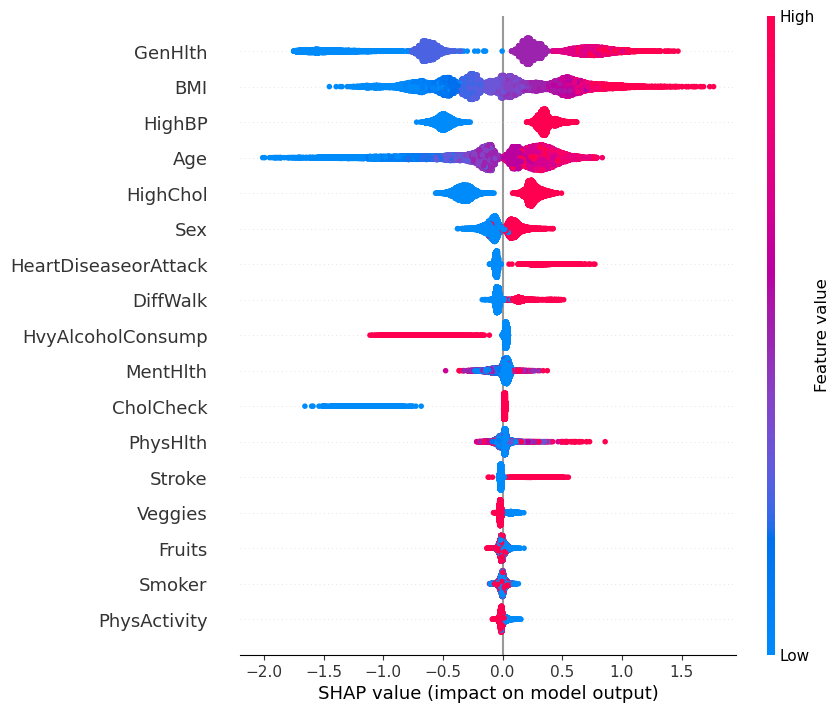

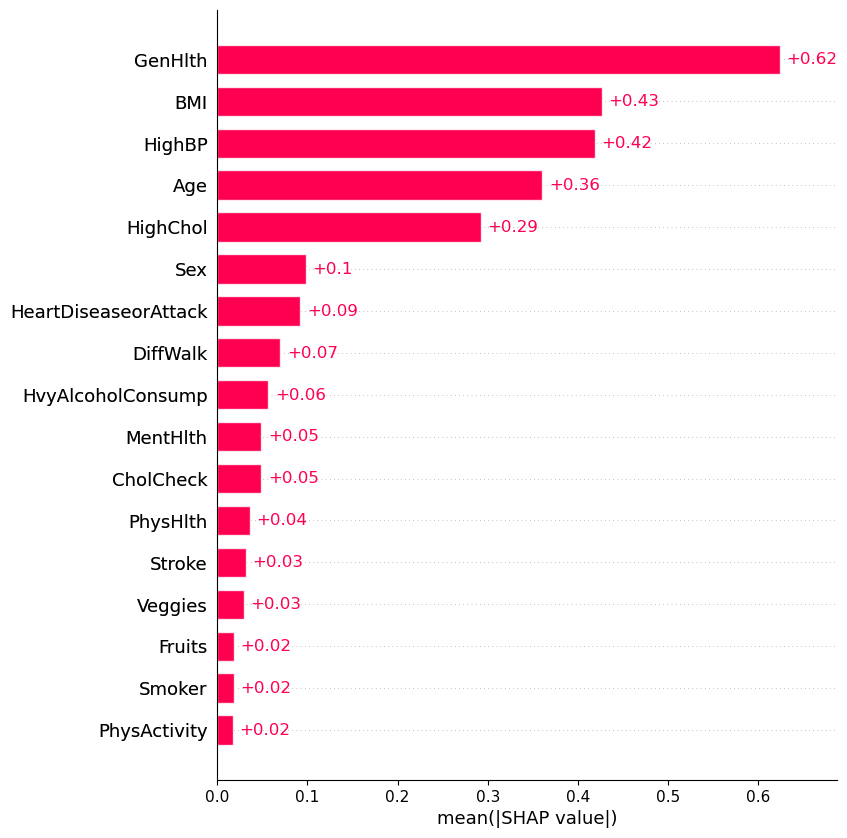

,mean|SHAP|
GenHlth,0.623642
BMI,0.426350
HighBP,0.418404
Age,0.360528
HighChol,0.292259
Sex,0.098541
HeartDiseaseorAttack,0.091989
DiffWalk,0.069859
HvyAlcoholConsump,0.056470
MentHlth,0.049090


In [13]:
# Inserte código para generar gráficos de aporte global aquí
sv_global = get_sv_cached()

# Beeswarm y barras
shap.plots.beeswarm(sv_global, max_display=20, show=True)
shap.plots.bar(sv_global, max_display=20, show=True)

# Tabla mean(|SHAP|)
feat_names = sv_global.feature_names
mean_abs = np.abs(sv_global.values).mean(axis=0)
imp_global = pd.Series(mean_abs, index=feat_names, name="mean|SHAP|").sort_values(ascending=False)
display(imp_global.to_frame())

Notamos que la barra de mean(|SHAP|) resume el impacto medio absoluto de cada variable sobre el log-odds a lo largo de todas las personas (magnitud, no dirección). El ranking obtenido:

1. GenHlth (≈0.62) domina: la autopercepción de salud condensa múltiples factores de riesgo.
2. BMI (≈0.43) y HighBP (≈0.42) aportan casi por igual: exceso de peso e hipertensión explican gran parte de la variación del score.
3. Age (≈0.36) y HighChol (≈0.29) siguen con peso sustantivo.
4. El resto (Sex, HeartDiseaseorAttack, DiffWalk, HvyAlcoholConsump, MentHlth, CholCheck, PhysHlth, Stroke, Veggies, Fruits, Smoker, PhysActivity) tienen contribuciones decrecientes.

En términos prácticos si se busca reducir complejidad, ese “top-5” explica la mayor parte del empuje predictivo del modelo a nivel poblacional.

#### ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

* Agregación vs. individualización.
  Global SHAP mide magnitud promedio; no dice si el efecto es hacia ↑ o ↓ para un paciente concreto. En los waterfalls locales:

  * Instancia 1 y 150: `GenHlth=4`, `HighBP=1`, `HighChol=1` y mayor `Age` empujaron ↑ el riesgo.
  * Instancia 9: `Age=5`, `GenHlth=2`, `HighBP=0`, `HighChol=0` empujaron ↓ el riesgo.
    Esto ilustra que una variable muy importante globalmente puede tener signo opuesto en un individuo (p. ej., `BMI=26` redujo el score en la instancia 150, aunque globalmente `BMI` sea muy influyente).

* Heterogeneidad y no linealidad.
  El global oculta umbrales e interacciones capturados en los casos (p. ej., `BMI` cambia de signo alrededor de ≈30 y su efecto depende de `Age`/`HighBP`). Para ver dirección y heterogeneidad conviene el beeswarm (coloreado por el valor de la feature) y, en la siguiente sección, PDP/ICE.

* Consistencia con PFI.
  El núcleo (`GenHlth`, `BMI`, `Age`, `HighBP`, `HighChol`) coincide con PFI; cambian ligeramente los órdenes (p. ej., `HighBP` 3º aquí vs 4º en PFI), lo que es esperable porque PFI mide caída de métrica global al romper una columna, mientras que mean(|SHAP|) resume la magnitud local promedio de los aportes.

Es decir, global SHAP confirma qué variables explican más al conjunto; las explicaciones locales indican por qué cada paciente fue clasificado como fue (incluyendo signo y contexto).

### 5.4 Scatter plot (4 puntos)


Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

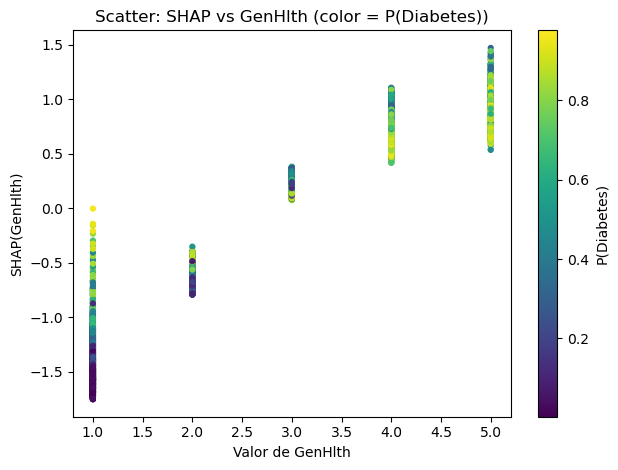

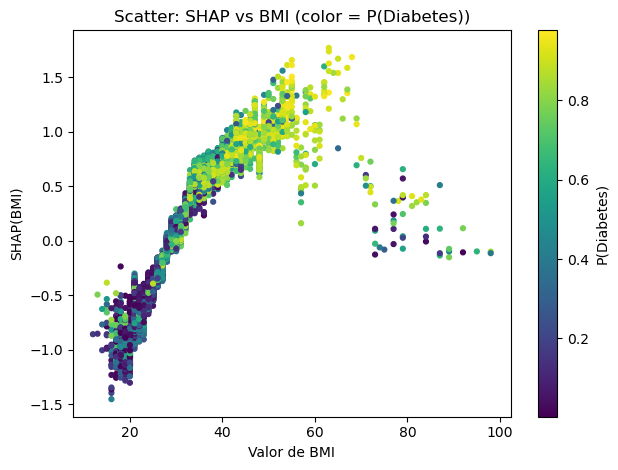

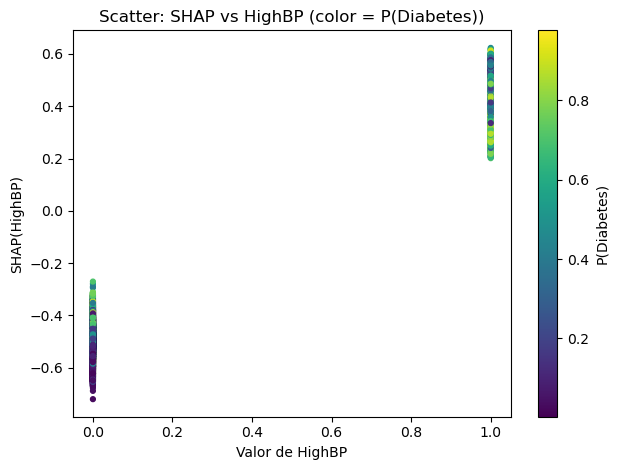

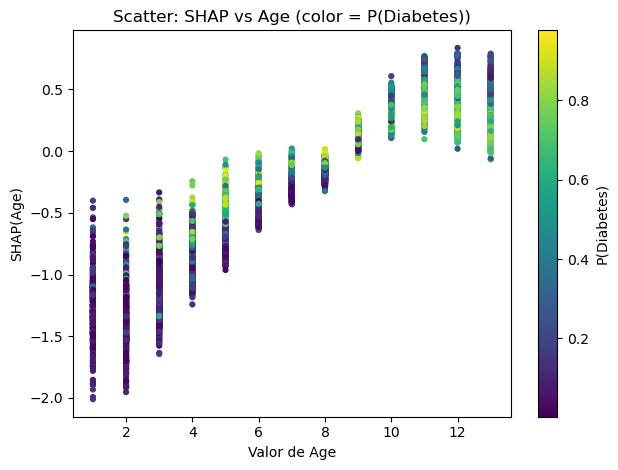

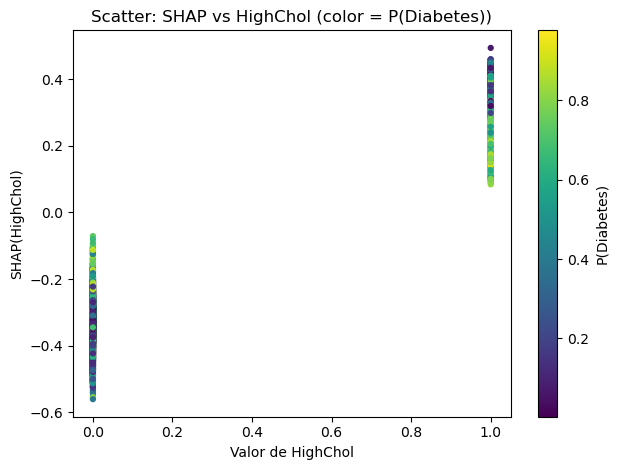

In [14]:
# Inserte código para generar gráficos de feature vs shap value aquí
sv_ = get_sv_cached()
Xtt_df = pd.DataFrame(sv_.data, columns=sv_.feature_names, index=X_test.index)

top5_feats, _ = top_k_by_mean_abs_shap(sv_, k=5)

# probabilidad del modelo
p_diab = pipe.predict_proba(X_test)[:, 1]

# un gráfico por feature
for f in top5_feats:
    y = sv_.values[:, sv_.feature_names.index(f)]
    x = Xtt_df[f].values
    plt.figure()
    sc = plt.scatter(x, y, c=p_diab, s=12)
    plt.colorbar(sc, label="P(Diabetes)")
    plt.xlabel(f"Valor de {f}")
    plt.ylabel(f"SHAP({f})")
    plt.title(f"Scatter: SHAP vs {f} (color = P(Diabetes))")
    plt.tight_layout(); plt.show()

#### Conclusiones del *scatter* SHAP vs feature (color = P(Diabetes))

* GenHlth (1–5, peor→mejor?): patrón monótono.  
  Valores bajos (1–2) tienen SHAP < 0 (reducen riesgo); valores altos (4–5) SHAP > 0 (aumentan riesgo). La barra de color acompaña: a mayor SHAP, mayor probabilidad. Muestra que el estado de salud auto-reportado es un resumen fuerte de riesgo.

* BMI (continuo): relación no lineal con umbral.    
  Bajo ~25 ⇒ SHAP < 0; alrededor de 30–35 cruza a SHAP > 0 (zona de mayor empuje), y parece saturar entre ~40–60; en valores extremos muy altos el aporte tiende a disminuir (pocos datos + interacciones). La nube vertical (mismo BMI con SHAP distinto) evidencia interacciones con otras variables (p. ej., HighBP/GenHlth/Age).

* Age (ordinal 1–13): creciente casi por tramos lineales.   
  Jóvenes: SHAP < 0; edades altas: SHAP > 0. De nuevo, color más “amarillo” (probabilidad alta) acompaña a SHAP positivo.

* HighBP (0/1): dos bandas bien separadas.    
  `0` ⇒ SHAP < 0 (protege); `1` ⇒ SHAP > 0 (riesgo). La dispersión vertical dentro de cada banda muestra que el impacto de hipertensión depende del contexto (p. ej., con `GenHlth` alto o `BMI` alto empuja más).

* HighChol (0/1): mismo patrón que HighBP, con magnitud algo menor: `0` negativo, `1` positivo.

Esas fueron las apreciaciones por cada gráfico, ahora algunas conclusiones generales:

* El gradiente de color sigue el eje-y (SHAP): a mayor contribución positiva, mayor $P(\text{Diabetes})$, lo que valida la coherencia entre salida en log-odds y probabilidad.
* En continuas/ordinales (`BMI`, `Age`, `GenHlth`) aparecen umbrales y no linealidades; en binarias (`HighBP`, `HighChol`) hay saltos limpios entre 0 y 1.
* La variabilidad vertical a un mismo valor de la feature refleja interacciones capturadas por XGBoost: la influencia de una variable cambia según las demás.

Es decir, las cinco variables top muestran relaciones clínicamente razonables (edad, salud general, obesidad, hipertensión y colesterol elevan el riesgo). `BMI` destaca por su forma no lineal con umbral (~30), mientras que `Age` y `GenHlth` exhiben incrementos casi monótonos. Las binarias (`HighBP`, `HighChol`) actúan como “interruptores” cuyo efecto se modula por el contexto del paciente.

### 5.5 Partial Dependence Plot (4 puntos)

Finalmente, se le pide generar un gráfico del tipo Partial Dependence Plot para las mismas 5 variables con mayor impacto global usando una submuestra de 1000 observaciones. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

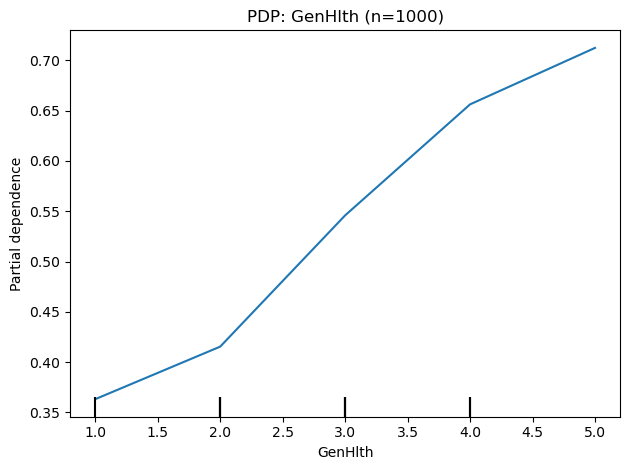

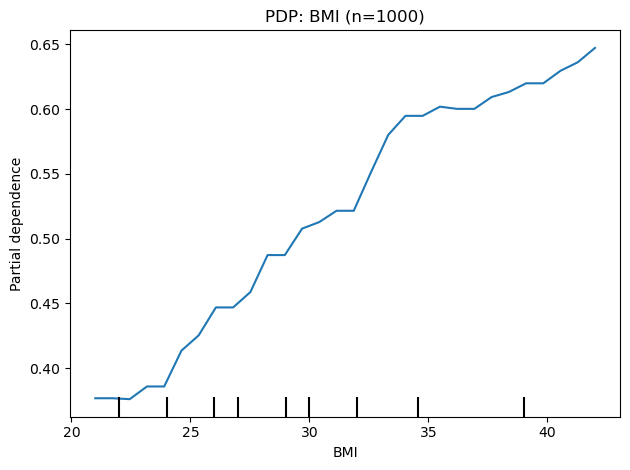

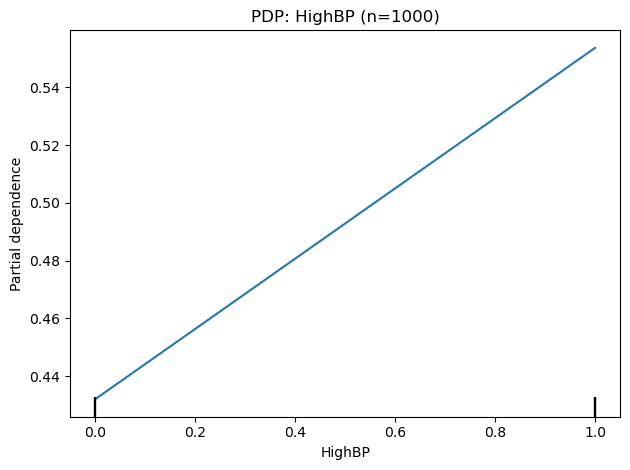

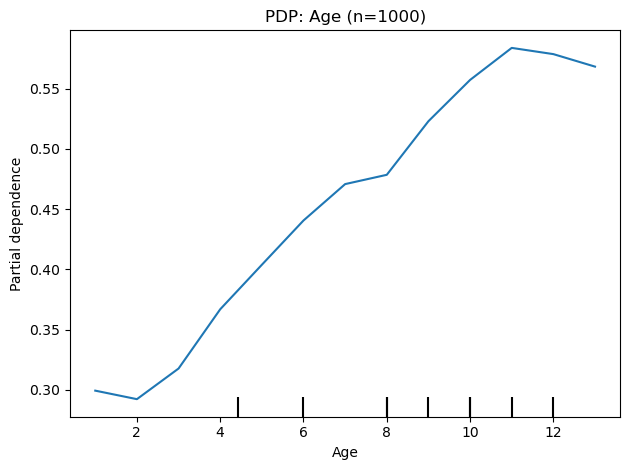

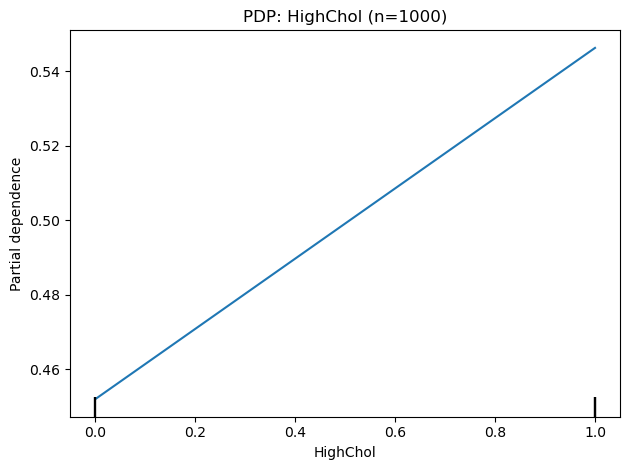

In [15]:
# Inserte código para generar gráficos PDP aquí
sv_ = get_sv_cached()
top5_feats, _ = top_k_by_mean_abs_shap(sv_, k=5)

# Submuestra de 1000 observaciones (sobre test para evaluar generalización)
S = X_test.sample(n=min(1000, len(X_test)), random_state=42)

# PDP individuales (salida en probabilidad de clase positiva)
for f in top5_feats:
    PartialDependenceDisplay.from_estimator(
        pipe, S, features=[f],
        kind="average", grid_resolution=30,
        response_method="predict_proba"
    )
    plt.title(f"PDP: {f} (n={len(S)})")
    plt.tight_layout(); plt.show()

#### ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada?

* GenHlth (1→5): relación monótona creciente. La probabilidad media sube aprox. de 0.36 (valor=1) a 0.71 (valor=5). Mayor pendiente entre 3→4. Es la curva más influyente en promedio.

* BMI (≈21→42): creciente no lineal con cambio de pendiente alrededor de ≈30 (umbral de obesidad). Desde ~0.38 hasta ~0.65; ligera meseta sobre 35–40, consistente con saturación del efecto y menor densidad de datos extremos.

* Age (1→13): creciente casi por tramos lineales; pasa de ~0.29 a ~0.57–0.59. La leve caída final (12→13) sugiere escasez de observaciones en el tope o interacción con otras variables.

* HighBP (0→1): salto discreto de ~0.43 (no hipertenso) a ~0.55 (hipertenso); +0.12 de probabilidad media.

* HighChol (0→1): salto de ~0.45 a ~0.55; +0.10 de probabilidad media.

#### ¿Son estas conclusiones generalizables para todo el conjunto de datos?

En términos cualitativos, sí: son consistentes con

* el ranking global (mean|SHAP|),
* la PFI en test, y
* los *scatter* SHAP (que ya mostraban monotonicidad/umbrales).

Sin embargo, hay algunas limitaciones del PDP:

* Es un promedio marginal; oculta heterogeneidad e interacciones (ej., el efecto de BMI depende de `HighBP` y `Age`).
* Puede evaluar combinaciones off-manifold si hay correlaciones fuertes (p. ej., `Age` con `HighBP`/`HighChol`).
* La ligera oscilación en extremos (Age=13, BMI>40) puede deberse a baja cobertura.

Por ello, se toma los PDP como tendencias globales; para grupos o individuos concretos, se usa ICE/SHAP local y, si se requiere mayor rigor, PDP condicional o estratificado (p. ej., por grupos de edad o hipertensión).

## 6. Sistema de Reglas! (10 punto)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo.
En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

`Hint:` Como debe entregar las columnas que entran al clasificador entrenado de su pipeline, le será útil extraer el paso de preprocesamiento y generar dataframes preprocesados para el conjunto `train` y `test`.

In [16]:
!pip install alibi

In [17]:
from alibi.explainers import AnchorTabular

In [ ]:
# Inserte su código para generar sistema de reglas aquí

# Datos preprocesados (mismo orden/espacio que el clasificador del pipeline)
pre = pipe.named_steps["pre"]

def _feat_names(pre, X):
    try:
        return list(pre.get_feature_names_out())
    except Exception:
        return list(X.columns)

def to_preprocessed_df(X):
    Xt = pre.transform(X)
    if not isinstance(Xt, pd.DataFrame):
        Xt = pd.DataFrame(Xt, columns=_feat_names(pre, X), index=X.index)
    return Xt

Xtr_t = to_preprocessed_df(X_train)
Xte_t = to_preprocessed_df(X_test)
Xall_t = pd.concat([Xtr_t, Xte_t], axis=0)
y_all  = pd.concat([y_train, y_test], axis=0).astype(int)

feat_names = list(Xtr_t.columns)

# Explainer AnchorTabular
def predict_fn(x_np):
    # x_np llega como ndarray en el espacio preprocesado
    Xdf = pd.DataFrame(x_np, columns=feat_names)
    return pipe.named_steps["clf"].predict(Xdf).astype(int)

try:
    explainer = AnchorTabular(predict_fn, feature_names=feat_names, discretizer="quartile", seed=42)
    explainer.fit(Xtr_t.values)
except TypeError:
    explainer = AnchorTabular(predict_fn, feature_names=feat_names, seed=42)
    explainer.fit(Xtr_t.values, disc_perc=(25, 50, 75))

# Funciones: explicar y evaluar reglas de forma empírica
_interval_re = re.compile(
    r"^\s*([-+]?\d*\.?\d+)\s*<\s*(.+?)\s*<=\s*([-+]?\d*\.?\d+)\s*$"
)
_comp_re = re.compile(
    r"^\s*(.+?)\s*(<=|>=|=|<|>)\s*([-+]?\d*\.?\d+)\s*$"
)

def _cond_mask(cond: str, Xdf: pd.DataFrame) -> pd.Series:
    cond = cond.strip().replace(",", ".")  # decimales consistentes
    m = _interval_re.match(cond)
    if m:
        lo, feat, hi = float(m.group(1)), m.group(2).strip(), float(m.group(3))
        return (Xdf[feat] > lo) & (Xdf[feat] <= hi)
    m = _comp_re.match(cond)
    if m:
        feat, op, val = m.group(1).strip(), m.group(2), float(m.group(3))
        if op == "<=":  return Xdf[feat] <= val
        if op == "<":   return Xdf[feat] <  val
        if op == ">=":  return Xdf[feat] >= val
        if op == ">":   return Xdf[feat] >  val
        if op == "=":   return Xdf[feat] == val
    # Fallback: igualdad literal (por si aparece categórica textual)
    if "=" in cond:
        feat, v = [t.strip() for t in cond.split("=", 1)]
        try:   v = float(v);  return Xdf[feat] == v
        except ValueError:    return Xdf[feat].astype(str).str.strip() == v
    raise ValueError(f"No pude interpretar la condición: {cond}")

def rule_mask(rule_conditions, Xdf):
    mask = pd.Series(True, index=Xdf.index)
    for c in rule_conditions:
        mask &= _cond_mask(c, Xdf)
    return mask.values  # boolean np.array

def anchor_for_test_idx(idx: int, threshold: float = 0.95):
    x_row = Xte_t.iloc[[idx]].values[0]
    exp = explainer.explain(x_row, threshold=threshold)
    y_hat = int(predict_fn(x_row.reshape(1, -1))[0])
    return {
        "idx": idx,
        "rule": list(exp.anchor),
        "model_label": y_hat,
        "anchor_precision_est": float(exp.precision),
        "anchor_coverage_est": float(exp.coverage),
        "exp": exp
    }

def evaluate_rule_on_all(rule_conditions, rule_label, Xdf, y_true):
    m = rule_mask(rule_conditions, Xdf)
    covered = int(m.sum())
    coverage_frac = covered / len(Xdf)
    if covered == 0:
        return {"covered": 0, "coverage_frac": 0.0, "precision": np.nan, "mask": m}
    precision = float((y_true[m].values == rule_label).mean())
    return {"covered": covered, "coverage_frac": coverage_frac, "precision": precision, "mask": m}

# Explicar idx solicitados y evaluar
targets = [1000, 3001, 5751]
expls = [anchor_for_test_idx(i, threshold=0.95) for i in targets]

rows = []
for e in expls:
    ev = evaluate_rule_on_all(e["rule"], e["model_label"], Xall_t, y_all)
    rows.append({
        "idx": e["idx"],
        "rule": " AND ".join(e["rule"]),
        "model_label": e["model_label"],
        "anchor_precision_est": e["anchor_precision_est"],
        "anchor_coverage_est": e["anchor_coverage_est"],
        "empirical_covered": ev["covered"],
        "empirical_coverage_frac": ev["coverage_frac"],
        "empirical_precision": ev["precision"]
    })
rules_df = pd.DataFrame(rows).sort_values("empirical_coverage_frac", ascending=False)
display(rules_df)

# Cobertura y precisión conjunta (unión de reglas) y política de resolución de solapes
masks = np.column_stack([rule_mask(e["rule"], Xall_t) for e in expls])  # shape (N, 3)
union_mask = masks.any(axis=1)
union_covered = int(union_mask.sum())
union_coverage_frac = union_covered / len(Xall_t)

# Regla aplicada por fila cubierta: priorizar más específica (más condiciones) y, en empate, mayor precision_est
conds_len = np.array([len(e["rule"]) for e in expls], dtype=int)
prec_est = np.array([int(round(e["anchor_precision_est"] * 1e6)) for e in expls], dtype=int)  # para ordenar
priority = conds_len * 10**6 + prec_est
choice = masks.astype(int) * priority[None, :]
best_rule_idx = choice.argmax(axis=1)

labels = np.array([e["model_label"] for e in expls], dtype=int)
y_rule_pred = np.where(union_mask, labels[best_rule_idx], -1)

correct_on_covered = (y_all.values[union_mask] == y_rule_pred[union_mask]).sum()
precision_on_covered = correct_on_covered / union_covered if union_covered > 0 else np.nan
precision_over_total = correct_on_covered / len(Xall_t)  # precisión "global" si tratamos no cubiertos como abstención

print(f"Cobertura conjunta (unión): {union_covered} / {len(Xall_t)} = {union_coverage_frac:.3f}")
print(f"Precisión empírica en cubiertos (y == regla): {precision_on_covered:.3f}")
print(f"Precisión escalada a todo el conjunto (correctos / N): {precision_over_total:.3f}")

# vista rápida de solapes por regla
overlap_counts = masks.sum(axis=0)  # cuántas filas cubre cada regla
print("Cobertura individual (conteo):", dict(zip(targets, overlap_counts.tolist())))

,idx,rule,model_label,anchor_precision_est,anchor_coverage_est,empirical_covered,empirical_coverage_frac,empirical_precision
1,3001,GenHlth > 2.00 AND HighBP > 0.00 AND Age > 9.00,1,0.953722,0.2132,14960,0.211622,0.764706
0,1000,GenHlth > 2.00 AND DiffWalk > 0.00 AND Age > 9...,1,0.994302,0.0928,6687,0.094593,0.814715
2,5751,GenHlth > 3.00 AND HeartDiseaseorAttack > 0.00,1,0.985507,0.0827,5596,0.079160,0.825232


Cobertura conjunta (unión): 18633 / 70692 = 0.264
Precisión empírica en cubiertos (y == regla): 0.768
Precisión escalada a todo el conjunto (correctos / N): 0.202
Cobertura individual (conteo): {1000: 6687, 3001: 14960, 5751: 5596}


#### Reglas y explicación de las observaciones solicitadas

* Obs. 1000 — Regla: `GenHlth > 2` AND `DiffWalk > 0` AND `Age > 9` → predicción del modelo: 1  
  Lectura: peor salud auto-reportada, dificultad para caminar y edad alta. Es congruente con los *SHAP* locales (estas variables empujan el log-odds hacia 1) y con PFI/SHAP global (son de las más influyentes).   
  Impacto en población: explica 9.46% del total con 81.5% de precisión empírica.

* Obs. 3001 — Regla: `GenHlth > 2` AND `HighBP > 0` AND `Age > 9` → predicción: 1   
  Lectura: mala salud auto-reportada + hipertensión + edad alta. Coincide con el patrón clínico que vimos (riesgo cardiometabólico).    
  Impacto: mayor cobertura (21.16%) con 76.5% de precisión.

* Obs. 5751 — Regla: `GenHlth > 3` AND `HeartDiseaseorAttack > 0` → predicción: 1   
  Lectura: salud auto-reportada aún peor y antecedente cardiovascular; ambos elevan el riesgo en los análisis globales y locales.   
  Impacto: 7.92% de cobertura con 82.5% de precisión.

Conclusión por caso: las tres reglas “capturan” exactamente los determinantes que el modelo usa en esas observaciones y, además, son intuitivas para comunicar al paciente (edad alta, comorbilidades cardiometabólicas y peor estado general).

#### ¿A cuánta población explican y con qué precisión “en la totalidad de los datos”?

* Cobertura conjunta (explicables por al menos una regla): 26.4% del dataset (18.633 personas).
* Precisión empírica en los cubiertos (comparada con la verdad): 76.8%.

  > Si se quisiera una métrica “global” sobre el universo, considerando que las reglas no clasifican al 73.6% restante (abstención), la tasa de aciertos de las reglas respecto del total es 20.2% (= 0.768 × 0.264). Para el resto, se mantiene el clasificador XGBoost o se agregan nuevas reglas.

#### ¿Tienen sentido las reglas propuestas para las observaciones?

Sí. Son coherentes con el modelo y con la clínica:

* `GenHlth`, `Age`, `HighBP`, `HeartDiseaseorAttack` y `DiffWalk` aparecieron antes como variables dominantes (PFI/SHAP).
* Cada regla representa escenarios clínicos plausibles de alto riesgo (edad alta + comorbilidad + mal estado de salud percibida).

Impacto global: con solo tres reglas simples se explica ≈¼ de las decisiones con ≈77% de precisión en los casos cubiertos. Los solapes entre reglas son sustantivos (~46% de los cubiertos), lo que sugiere que capturan perfiles de riesgo afines; si quisiéramos elevar cobertura o precisión, podemos:

* añadir anclas adicionales (p. ej., perfiles con `BMI` alto pero sin cardiopatía),
* subir el umbral de `Age`/`GenHlth` para ganar precisión a costa de cobertura, o
* segmentar (reglas estratificadas por edad o hipertensión).

Como resumen para el Dr. Simi podríamos decirle:

> “Con tres reglas claras y alineadas con la práctica clínica podemos explicar el 26% de los pacientes a los que el modelo etiqueta con riesgo, con cerca de un 77% de acierto en ese grupo. Para los no cubiertos seguimos usando el modelo o agregamos nuevas reglas para ampliar cobertura.”

# Retrospectiva... (10 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

#### ¿Qué métodos entregan mejores conclusiones para la tarea de clasificación de diabetes?

* Para entender “qué variables importan” de forma robusta:      
  Permutation Feature Importance (PFI) en *test* y SHAP global (mean|SHAP|). Ambos coincidieron en el núcleo {`GenHlth`, `BMI`, `HighBP`, `Age`, `HighChol`} y, a diferencia de las importancias internas de XGBoost (*weight/cover/gain*), son menos sensibles a sesgos por cardinalidad o a la dinámica del entrenamiento.        
  *Conclusión:* PFI + SHAP global proporcionan el ranking más fiable para priorizar factores y para gobernanza del modelo.

* Para entender “cómo” influyen (dirección y forma):        
  PDP/ICE y los scatter SHAP (feature vs SHAP). Observamos relaciones monótonas (`Age`, `GenHlth`) y no lineales con umbral (p. ej., `BMI`≈30). Esto complementa al ranking: no basta saber que `BMI` importa, hay que ver dónde y cómo impacta.

* Para justificar decisiones concretas (por paciente):      
  SHAP local (waterfalls) explica el signo y la magnitud de cada variable para la predicción individual; es fiel al modelo (reconstruyó la probabilidad con error ≈1.8e−7).     
  Anchors (reglas) dan un relato discreto y accionable: con 3 reglas explicamos ~26.4% de la población cubierta con ≈76.8% de precisión empírica; son comprensibles, aunque su cobertura es limitada y su precisión cae respecto del clasificador.

* Importancias internas de XGBoost: útiles como diagnóstico rápido, pero inferiores para conclusiones: *weight/cover/gain* divergen y presentan sesgos conocidos; deben contrastarse siempre con PFI/SHAP.

#### ¿Qué métodos son más útiles para el problema del doctor Simi, métodos agnósticos locales o globales?

* Para comunicación clínica con el paciente (caso a caso):      
  Locales (SHAP local, Anchors). Permiten decir “*su riesgo sube por X, Y, Z*” y ofrecen reglas simples (“*si GenHlth>2 y HighBP=1 y Age>9, entonces…*”). Son los más pertinentes para consentimiento informado y educación del paciente.

* Para gestión y toma de decisiones a nivel de clínica (políticas, priorización, auditoría):    
  Globales (PFI en test, SHAP global, PDP/ICE). Responden “*¿qué factores mueven el modelo en promedio?*”, “*¿dónde están los umbrales útiles?*” y permiten detectar desplazamientos de distribución o riesgos de proxy.

Recomendación de uso combinado (pipeline de interpretabilidad):

1. Validar desempeño (ROC AUC 0.828; AUC-PR 0.801).
2. Ranking global con PFI + SHAP global.
3. Forma/dirección con PDP/ICE (y estratos si hay correlación).
4. Explicación individual con SHAP local; cuando se requiera simplicidad, Anchors para reglas de alto *precision* y cobertura razonable.
5. Monitoreo periódico: repetir PFI/SHAP global para asegurar estabilidad.

En síntesis, PFI + SHAP (global/local) + PDP fueron los métodos que mejor sostuvieron conclusiones útiles y estables; para el objetivo práctico del Dr. Simi (explicar a personas reales su predicción), los métodos locales son los que aportan mayor valor, mientras que los globales son esenciales para gobernanza y mejora continua del modelo.